In [1]:
import pandas as pd
import numpy as np
import matplotlib

from ecog_speech import datasets, feature_processing, models, utils

%matplotlib inline

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


Data from all patient_tuples is read and parsed for speaking/no-speaking regions (can be extended to other objectives)

In [2]:
nww = datasets.NorthwesternWords(patient_tuples=[('Mayo Clinic', 19, 1, 1)])
#nww = datasets.ChangNWW(patient_tuples=[('Mayo Clinic', 19, 1, 1)])

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torchaudio/functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


---19-1-1-Mayo Clinic---
Duplicate words (n=2): pig, cup
ECOG_signal shape: (422400, 96) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.999166667'))]
Selected sensors (n=64): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63
Audio shape: (16887643,) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.825875'))]

--
remap: ecog <- ecog_subs
remap: fs_signal <- fs_signal_subs
remap: stim <- stim_subs
remap: stim_diff <- stim_diff_subs
Sample Words: 0-much,1-fish,2-ride,3-bit,4-dill
(600, Timedelta('0 days 00:00:00.500000'))
Max window size: 300


****

In [3]:
data_map = nww.data_maps[('Mayo Clinic', 19, 1, 1)]

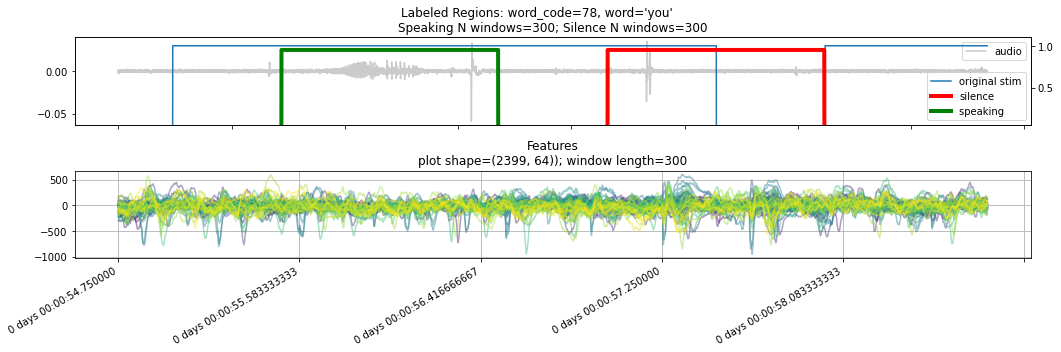

In [4]:
# run without giving word_code to get a random sample
fig, ax = nww.plot_word_sample_region(data_map, plot_features=True)

### nww dataset

#### The a flat mapping of objects describing the sample windows is stored as `flat_index_map`
- First 3 keys and values below
- Key must identify the class as well as sample id (first two positions)

In [5]:
list(nww.flat_index_map.keys())[:3], list(nww.flat_index_map.values())[:3]

([(-1, 0, 'Mayo Clinic', 19, 1, 1),
  (-1, 1, 'Mayo Clinic', 19, 1, 1),
  (-1, 2, 'Mayo Clinic', 19, 1, 1)],
 [TimedeltaIndex([          '0 days 00:04:57', '0 days 00:04:57.001666667',
                  '0 days 00:04:57.003333333',    '0 days 00:04:57.005000',
                  '0 days 00:04:57.006666667', '0 days 00:04:57.008333333',
                     '0 days 00:04:57.010000', '0 days 00:04:57.011666667',
                  '0 days 00:04:57.013333333',    '0 days 00:04:57.015000',
                  ...
                  '0 days 00:04:57.483333333',    '0 days 00:04:57.485000',
                  '0 days 00:04:57.486666667', '0 days 00:04:57.488333333',
                     '0 days 00:04:57.490000', '0 days 00:04:57.491666667',
                  '0 days 00:04:57.493333333',    '0 days 00:04:57.495000',
                  '0 days 00:04:57.496666667', '0 days 00:04:57.498333333'],
                 dtype='timedelta64[ns]', length=300, freq=None),
  TimedeltaIndex(['0 days 00:04:57.0016666

#### Flat numpy array of tuples of keys - this is where we select into the data and get keys to other mapping structures

In [6]:
nww.flat_keys

array([[(-1, 0, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)],
       [(-1, 1, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)],
       [(-1, 2, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)],
       ...,
       [(115, 297, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)],
       [(115, 298, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)],
       [(115, 299, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)]],
      dtype=object)

In [7]:
nww.__len__??

Signature: nww.__len__()
Docstring: <no docstring>
Source:   
    def __len__(self):
        return len(self.selected_flat_keys)
File:      ~/Projects/CMSCResearch/ECOGSpeech/ecog_speech/datasets.py
Type:      method


In [8]:
nww.__getitem__??

Signature: nww.__getitem__(item)
Docstring: <no docstring>
Source:   
    def __getitem__(self, item):
        # ix_k includes the class and window id
        # data_k specifies subject dataset in data_map (less granular than ix_k)
        ix_k, data_k = self.selected_flat_keys[item]
        data_d = self.data_maps[data_k]

        # Put it all together (TODO: cleanup this interface)
        # TODO: Make features, make target methods?
        #so = self.make_sample_object(self.flat_index_map[ix_k],
        #                             ix_k[0], data_d['ecog'],
        #                             data_d['audio'],
        #                             ecog_transform=self.transform,
        #                             #max_ecog_samples=self.max_ecog_window_size,
        #                             mfcc_f=self.mfcc_m)
        so = self.get_features(data_d, self.flat_index_map[ix_k],
                               ix_k[0], ecog_transform=self.transform)
        so.update(self.get_targ

In [9]:
nww.flat_keys[:3,]

array([[(-1, 0, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)],
       [(-1, 1, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)],
       [(-1, 2, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)]],
      dtype=object)

In [10]:
nww.flat_keys.shape

(69000, 2)

In [11]:
nww.data_maps.keys()

dict_keys([('Mayo Clinic', 19, 1, 1)])

In [12]:
nww.default_ecog_sample_rate

1200

In [13]:
nww.fs_signal

600

In [14]:
pd.Series({k: len(v) for k, v in data_map['sample_index_map'].items()}).value_counts()

300    230
dtype: int64

### Models
Summary of modeling steps
- Load up additional data for CV and test
- Build model, partly based on the properties of the data
- Train model
- Run model on all partitions of data to get performance metrics (e.g. accuracy, f1)

**parse the 2nd trial for the same patient to use for CV**

In [15]:
cv_nww = datasets.NorthwesternWords(patient_tuples=[('Mayo Clinic', 19, 1, 2)])
#cv_nww = datasets.ChangNWW(patient_tuples=[('Mayo Clinic', 19, 1, 2)])

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torchaudio/functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


---19-1-2-Mayo Clinic---
Duplicate words (n=3): sip, sale, sick
ECOG_signal shape: (422400, 96) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.999166667'))]
Selected sensors (n=64): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63
Audio shape: (16894470,) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.968104167'))]

--
remap: ecog <- ecog_subs
remap: fs_signal <- fs_signal_subs
remap: stim <- stim_subs
remap: stim_diff <- stim_diff_subs
Sample Words: 0-cut,1-beat,2-heat,3-fit,4-pan
(600, Timedelta('0 days 00:00:00.500000'))
Max window size: 300


**parse 3rd trial for holdout**

In [16]:
test_nww = datasets.NorthwesternWords(patient_tuples=[('Mayo Clinic', 19, 1, 3)])
#test_nww = datasets.ChangNWW(patient_tuples=[('Mayo Clinic', 19, 1, 3)])

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torchaudio/functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


---19-1-3-Mayo Clinic---
Duplicate words (n=2): lick, pay
ECOG_signal shape: (422400, 96) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.999166667'))]
Selected sensors (n=64): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63
Audio shape: (16892541,) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.927916667'))]

--
remap: ecog <- ecog_subs
remap: fs_signal <- fs_signal_subs
remap: stim <- stim_subs
remap: stim_diff <- stim_diff_subs
Sample Words: 0-hook,1-tack,2-those,3-paw,4-yoke
(600, Timedelta('0 days 00:00:00.500000'))
Max window size: 300


****

In [17]:
from ecog_speech.models import base

In [18]:
nww.ecog_window_size

300

In [19]:
len(nww.sensor_columns)

64

In [20]:
nww.fs_signal

600

In [21]:
msinc_model = base.BaseMultiSincNN(in_channels=len(nww.sensor_columns), 
                                   window_size=nww.ecog_window_size,
                                   fs=nww.fs_signal,
                                   batch_norm=True,
                                   dropout=0.5, #dropout2d=True,
                                   sn_padding=15, n_cnn_filters=16,
                                   n_bands=2)

torch.Size([32, 272])
Unsqueeze()
torch.Size([32, 64, 1, 300])
----
MultiChannelSincNN(
  (sinc_nn): SincConv()
)
torch.Size([32, 64, 2, 300])
----
AlphaDropout(p=0.5, inplace=False)
torch.Size([32, 64, 2, 300])
----
Conv2d(64, 16, kernel_size=(1, 5), stride=(1, 5), dilation=(1, 2))
torch.Size([32, 16, 2, 59])
----
BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([32, 16, 2, 59])
----
SELU()
torch.Size([32, 16, 2, 59])
----
AlphaDropout(p=0.5, inplace=False)
torch.Size([32, 16, 2, 59])
----
Conv2d(16, 16, kernel_size=(1, 3), stride=(1, 3))
torch.Size([32, 16, 2, 19])
----
BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([32, 16, 2, 19])
----
SELU()
torch.Size([32, 16, 2, 19])
----
AlphaDropout(p=0.5, inplace=False)
torch.Size([32, 16, 2, 19])
----
Conv2d(16, 16, kernel_size=(2, 1), stride=(1, 1))
torch.Size([32, 16, 1, 19])
----
BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

**Turn datasets into dataloaders (wraps and adds multiprocess generation, batching, sampling)**

In [22]:
# setting num_workers to 0 means serial processing 
#- intended prevent windows OS multiproc bugs and join assertion errors in notebooks
dl_kws = dict(num_workers=0, batch_size=512,
                  shuffle=False, random_sample=True)

dl_map = dict(train=nww.to_dataloader(**dl_kws), 
              cv=cv_nww.to_dataloader(**dl_kws), 
              test=test_nww.to_dataloader(**dl_kws))

**Build trainer**

In [23]:
msinc_trainer = base.Trainer(dict(model=msinc_model), opt_map=dict(),
                             train_data_gen=dl_map['train'],
                             cv_data_gen=dl_map['cv'])

In [24]:
from torchvision import transforms

In [25]:
if False:
    msinc_trainer.transform = transforms.Compose([
            datasets.RollDimension(roll_dim=0,
                                   max_roll=nww.sensor_count - 1)
        ])

**Train!**

In [26]:
n_epochs = 10
msinc_res = msinc_trainer.train(n_epochs, 
                                batch_callbacks = dict(band_params=msinc_model.get_band_params))

<AxesSubplot:>

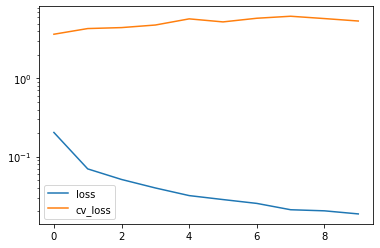

In [27]:
pd.DataFrame(msinc_res).T.plot(logy=True)

In [28]:
lowhz_df_map, highhz_df_map, centerhz_df_map = base.BaseMultiSincNN.parse_band_parameter_training_hist(msinc_trainer.batch_cb_history['band_params'],
                                                                                                      fs=600)

In [29]:
centerhz_df_map.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [30]:
msinc_trainer.best_model_epoch

0

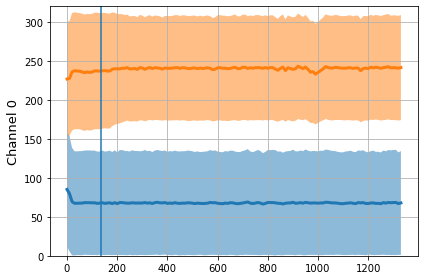

In [31]:
best_batch_i = (msinc_trainer.best_model_epoch + 1) * (len(dl_map['train']))

ax = None
ix_slice = slice(None, None, 10)
(ch_i, lowhz_df), (_, highhz_df), (_, centerhz_df) = ((0, lowhz_df_map[0]), 
                                                      (0, highhz_df_map[0]), 
                                                      (0, centerhz_df_map[0]))
#ax=axs.reshape(-1)[ch_i]
for c in lowhz_df.columns:
    ax = centerhz_df.loc[ix_slice][c].plot(ax=ax, lw=3)
    ax.fill_between(centerhz_df.loc[ix_slice].index,
                    lowhz_df.loc[ix_slice][c], 
                    highhz_df.loc[ix_slice][c], 
                    alpha=0.5)
ax.grid(True)
ax.set_ylim(0, 320)
#ax.set_xlim(0, centerhz_df.shape[0])
#ax.set_xlim(0, 35*len(dataloader))
#ax.set_title(ch_i)
ax.set_ylabel("Channel %d" % ch_i, fontsize=13)
ax.axvline(best_batch_i, label='Best model snapshot')
fig = ax.get_figure()
fig.tight_layout()

**Load snapshot of the model best model (last "NEW BEST")**

In [32]:
msinc_model.load_state_dict(msinc_trainer.get_best_state())
msinc_model.eval()

BaseMultiSincNN(
  (m): Sequential(
    (0): Unsqueeze()
    (1): MultiChannelSincNN(
      (sinc_nn): SincConv()
    )
    (2): AlphaDropout(p=0.5, inplace=False)
    (3): Conv2d(64, 16, kernel_size=(1, 5), stride=(1, 5), dilation=(1, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SELU()
    (6): AlphaDropout(p=0.5, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(1, 3), stride=(1, 3))
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): SELU()
    (10): AlphaDropout(p=0.5, inplace=False)
    (11): Conv2d(16, 16, kernel_size=(2, 1), stride=(1, 1))
    (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): SELU()
    (14): AlphaDropout(p=0.5, inplace=False)
    (15): Conv2d(16, 16, kernel_size=(1, 3), stride=(1, 1))
    (16): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (17): SELU()
    (18): Flatten()
   

Generate outputs - getting process join errors at end of each if num_workers > 0, but doesn't seem to impact output
- May be the tqdm progress bar?

In [33]:
msinc_outputs_map = msinc_trainer.generate_outputs(**dl_map)

In [34]:
perf_df = pd.DataFrame({partname: utils.performance(label_d['actuals'], label_d['preds'] > 0.5)
                for partname, label_d in msinc_outputs_map.items()})

<AxesSubplot:>

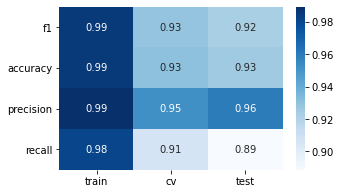

In [35]:
import seaborn as sns
fig, ax = matplotlib.pyplot.subplots(figsize=(5, 3))
sns.heatmap(perf_df, annot=True, cmap='Blues', ax=ax)


**plot and predict on a TEST sample**

In [36]:
#ix_max, ix_min = '60s', '5s'
ix_min, ix_max = '5s', '25s'

data_k = ('Mayo Clinic', 19, 1, 3)

data_map = test_nww.data_maps[data_k]

In [37]:
[('Mayo Clinic', 19, 1, 3)]

[('Mayo Clinic', 19, 1, 3)]

In [38]:
plt_stim_s = data_map['stim'].loc[ix_min:ix_max]

In [39]:
t_indices_s  = {wrd_id: (test_nww.sample_index_maps[data_k].get(wrd_id),  test_nww.sample_index_maps[data_k].get(-wrd_id))
                for wrd_id in plt_stim_s.unique() if wrd_id != 0}

In [40]:
t_indices_s.keys()

dict_keys([39, 24, 100, 31, 104, 27, 70])

In [41]:
import torch
from tqdm.auto import tqdm
ecog_torch_arr = torch.from_numpy(data_map['ecog'].values)

In [42]:
win_size = nww.ecog_window_size
win_step = 1
all_ecog_dl = torch.utils.data.DataLoader([ecog_torch_arr[_ix:_ix+win_size].T 
                                           for _ix in range(0, ecog_torch_arr.shape[0] - win_size, win_step)], 
                                          batch_size=1024, num_workers=6)


with torch.no_grad():
    all_ecog_out = [msinc_model(x) for x in tqdm(all_ecog_dl)]

In [43]:
all_ecog_pred_s = pd.Series([_v.item() for v in all_ecog_out for _v in v], 
          index=data_map['ecog'].iloc[range(win_size, ecog_torch_arr.shape[0], win_step)].index,
         name='pred_proba')

In [44]:
plt_dfs, neg_plt_dfs = list(), list()
for wrd_id, (wrd_ix, sil_ix)  in t_indices_s.items():
    #_cols = [f'neg_{wrd_id}', f'{wrd_id}']
    s = pd.Series(0, index=data_map['stim'].index, name=wrd_id)
    s.loc[wrd_ix[0].min():wrd_ix[-1].max()] = 1
    plt_dfs.append(s)
    
    s = pd.Series(0, index=data_map['stim'].index, name=-wrd_id)
    s.loc[sil_ix[0].min():sil_ix[-1].max()] = 1
    neg_plt_dfs.append(s)
    
plt_label_df = pd.concat(plt_dfs, axis=1)

In [45]:
all_ecog_pred_s.shape

(210900,)

In [46]:
plt_label_df.shape

(211200, 7)

<AxesSubplot:>

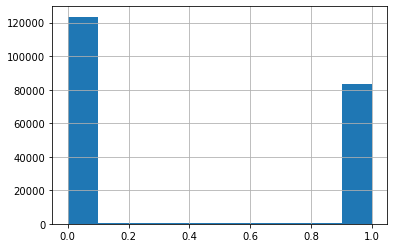

In [47]:
all_ecog_pred_s.hist()

In [48]:
all_ecog_pred_s

0 days 00:00:00.500000       3.055498e-39
0 days 00:00:00.501666666    0.000000e+00
0 days 00:00:00.503333333    0.000000e+00
0 days 00:00:00.505000       0.000000e+00
0 days 00:00:00.506666666    0.000000e+00
                                 ...     
0 days 00:05:51.991666667    0.000000e+00
0 days 00:05:51.993333333    0.000000e+00
0 days 00:05:51.995000       0.000000e+00
0 days 00:05:51.996666667    0.000000e+00
0 days 00:05:51.998333333    0.000000e+00
Name: pred_proba, Length: 210900, dtype: float64

**Put together naive sample by sample accuracy across entire dataset**

In [49]:
t_j_df = pd.concat([plt_label_df.any(1).rename('actual'), (all_ecog_pred_s > 0.5).rename('pred')], axis=1)

In [50]:
acc_arr = t_j_df['actual'].fillna(0).astype(int) == t_j_df['pred'].fillna(0).astype(int)

In [51]:
acc_arr.value_counts(normalize=True)

True     0.60776
False    0.39224
dtype: float64

<AxesSubplot:label='fb969f7a-157d-467b-a95c-15ba8aa41d9c', title={'center':'Labeled word regions and speech prediction'}>

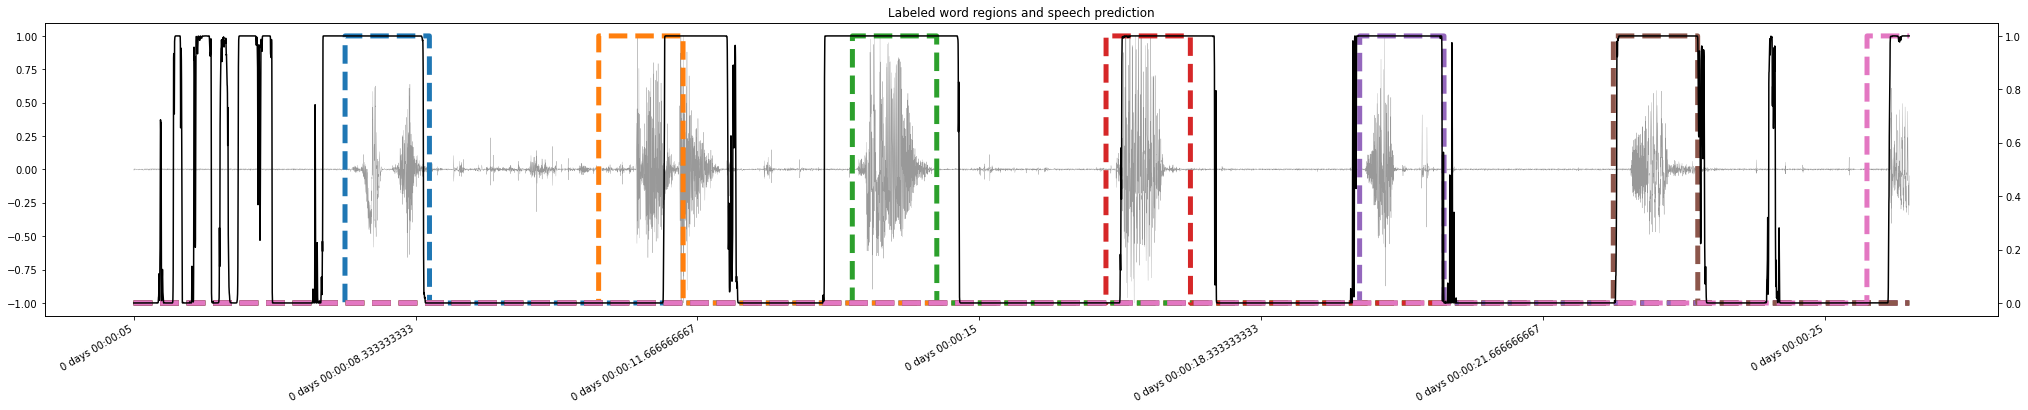

In [57]:
plt_audio = data_map['audio'].loc[ix_min:ix_max].reindex(plt_label_df.loc[ix_min:ix_max].index)

ax = (plt_audio/ plt_audio.quantile(0.999)).clip(-1, 1).plot(color='grey', alpha=0.8, lw=0.3)
ax2 = ax.twinx()
ax = plt_label_df.loc[ix_min:ix_max].plot(#color='tab:blue', 
    lw=5, ls='--', grid=True, legend=False, figsize=(35, 6), title='Labeled word regions and speech prediction',
ax=ax2)
all_ecog_pred_s.loc[ix_min:ix_max].plot(ax=ax2, color='black')

***

## Example data access - Accessing audio

In [27]:
nww.flat_keys[0][1]

('Mayo Clinic', 19, 1, 1)

<AxesSubplot:>

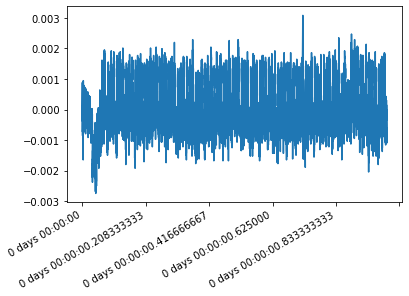

In [28]:
t_dmap = nww.data_map[nww.flat_keys[0][1]]
# show one second
t_dmap['audio'].iloc[:t_dmap['fs_audio']].plot()

In [29]:
import IPython

IPython.display.Audio(t_dmap['audio'].iloc[:t_dmap['fs_audio']*10].values, 
                      rate=t_dmap['fs_audio'])